__Preparing Data__

To model data with PyAutoLens, you first need to ensure it is in a format suitable for lens modeling. This tutorial takes you through what format to use, and will introduce a number of PyAutoLens's built in tools that can convert data from an unsuitable format.

In [ ]:
from autolens.data import ccd
from autolens.data.array import mask as ma
from autolens.lens import lens_data as ld
from autolens.data.plotters import ccd_plotters
from workspace.howtolens.loading_and_preparing_data import simulate_data

First, lets setup the path to our current working directory. I recommend you use the 'AutoLens/workspace' directory and that you place your data in the 'AutoLens/workspace/data' directory.

(for this tutorial, we'll use the 'AutoLens/workspace/howtolens/preparing_data' directory. The folder 'data' contains the example data-sets we'll use in this tutorial).

In [3]:
path = 'path/to/AutoLens/workspace/howtolens/chapter_2_lens_modeling/' # <----- You must include this slash on the end
path = '/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/loading_and_preparing_data/'
simulate_data.simulate_all_images() # This will populate the 'data' folder.

Lets load a data-set using the 'load_ccd_data_from_fits' function of the ccd module. This data-set represents a good data-reduction - it conforms to all the formatting standards I describe in this tutorial!

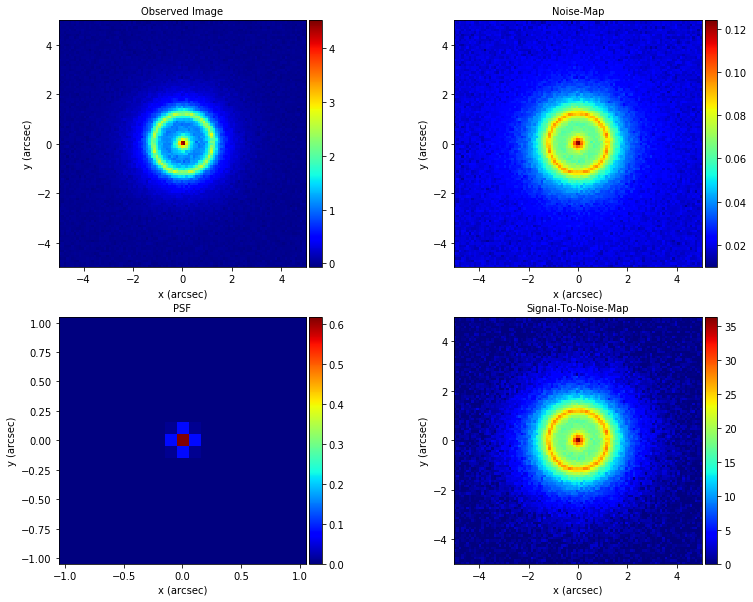

In [4]:
ccd_data = ccd.load_ccd_data_from_fits(image_path=path+'data/image/image.fits',
                                  noise_map_path=path+'data/image/noise_map.fits',
                                  psf_path=path+'data/image/psf.fits', pixel_scale=0.1)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)


If your data comes in one .fits file spread across multiple hdus, you can specify the hdus of each image instead.

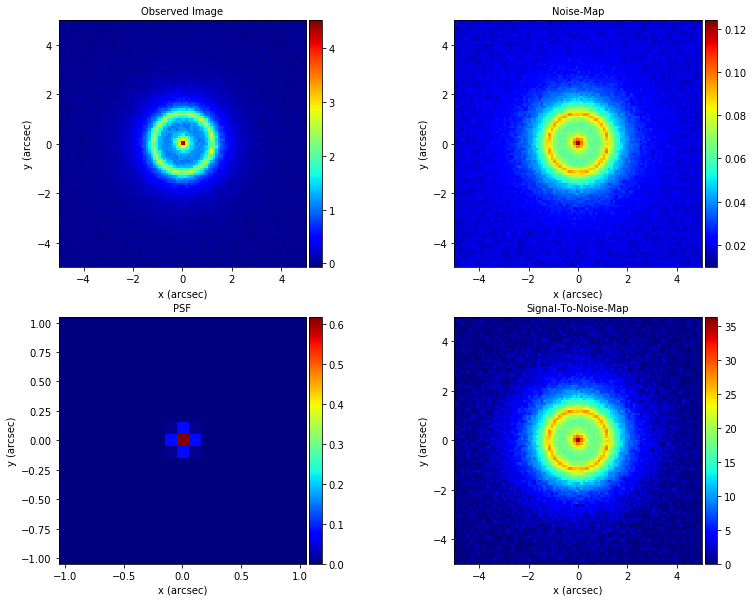

In [6]:
ccd_data = ccd.load_ccd_data_from_fits(image_path=path+'data/image/multiple_hdus.fits', image_hdu=0,
                                       noise_map_path=path+'data/image/multiple_hdus.fits', noise_map_hdu=1,
                                       psf_path=path+'data/image/multiple_hdus.fits', psf_hdu=2, pixel_scale=0.1)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

Now, lets think about the format and data-reduction of our data. There are numerous reasons why the image we just looked at is a good data-set for lens modeling. I strongly recommend you reduce your data to conform to the standards discussed below - it'll make your time using PyAutoLens a lot simpler.

However, you may not have access to the data-reduction tools that made the data, so we've included a number of in-built functions in PyAutoLens to convert the data to a good format for you. However, your life will be much easier if you can just reduce it this way in the first place!

1) Brightness units - the image's flux and noise-map values are in units of electrons per second (and not electrons, counts, ADU's etc.). Although PyAutoLens can technically perform an analysis using other units, the default settings assume the image is in electrons per second (e.g. the priors on light profile intensities and regularization coefficient). Thus, images not in electrons per second should be converted!

Lets look at an image that is in units of counts - its easy to tell because the peak values are in the 1000's or 10000's.

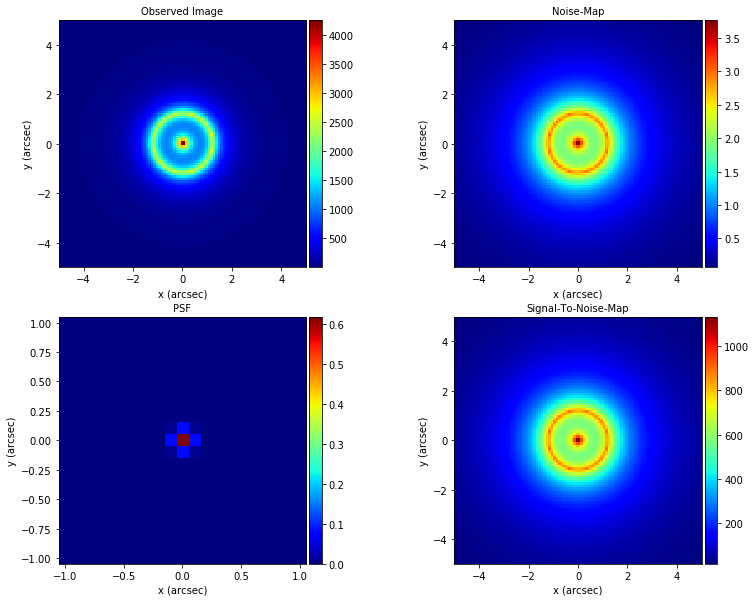

In [8]:
ccd_data_in_counts = ccd.load_ccd_data_from_fits(image_path=path+'data/image_in_counts/image.fits', pixel_scale=0.1,
                                  noise_map_path=path+'data/image_in_counts/noise_map.fits',
                                  psf_path=path+'data/image_in_counts/psf.fits')
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_in_counts)

If your image is in electrons (counts), you can convert it to electrons per second by supplying the function above with an exposure time and using the 'convert_arrays_from_counts' boolean flag.

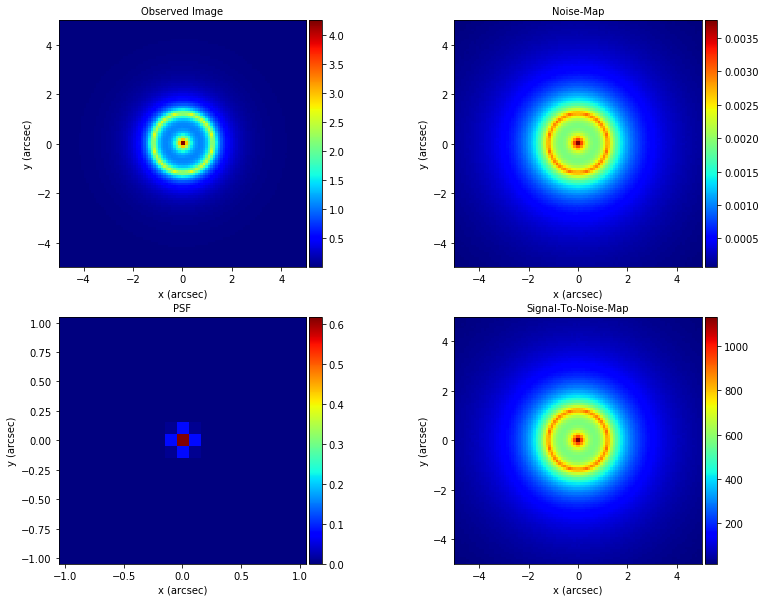

In [9]:
ccd_data_converted_to_eps = ccd.load_ccd_data_from_fits(image_path=path+'data/image_in_counts/regular.fits', pixel_scale=0.1,
                                                   noise_map_path=path+'data/image_in_counts/noise_map.fits',
                                                   psf_path=path+'data/image_in_counts/psf.fits',
                                                   exposure_time_map_from_single_value=1000.0, convert_from_electrons=True)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_converted_to_eps)

The effective exposure time in each pixel may vary. This occurs when data is reduced in a specific way, called 'dithering' and 'drizzling'. If you have access to an effective exposure-time map, you can use this to convert the image to electrons per second instead.

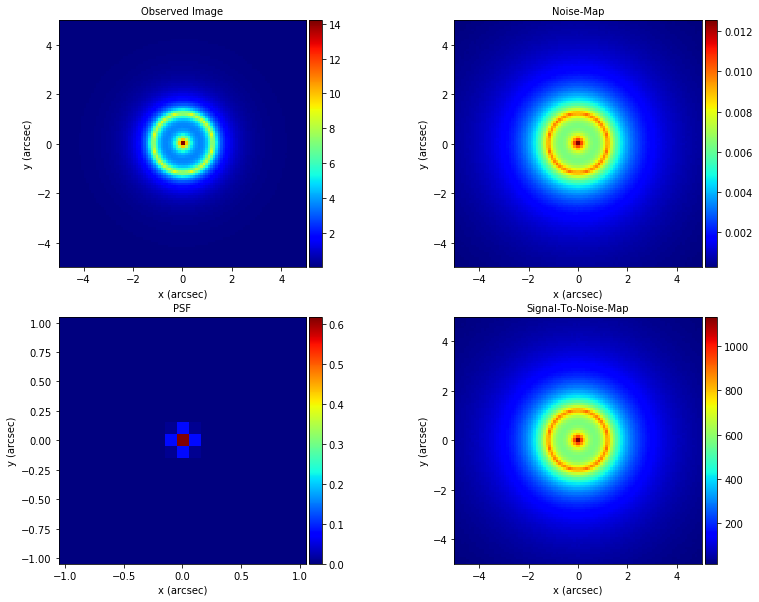

In [10]:
ccd_data_converted_to_eps = ccd.load_ccd_data_from_fits(image_path=path+'data/image_in_counts/regular.fits', pixel_scale=0.1,
                                                   noise_map_path=path+'data/image_in_counts/noise_map.fits',
                                                   psf_path=path+'data/image_in_counts/psf.fits',
                                                   exposure_time_map_path=path+'data/image_in_counts/exposure_time_map.fits',
                                                   convert_from_electrons=True)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_converted_to_eps)

2) Postage stamp size - The bigger the postage stamp cut-out of the image, the more memory it requires to store it. Why keep the edges surrounding the lens if there is no actual signal there?

Lets look at an example of a very large postage stamp - we can barely even see the lens and source galaxies!

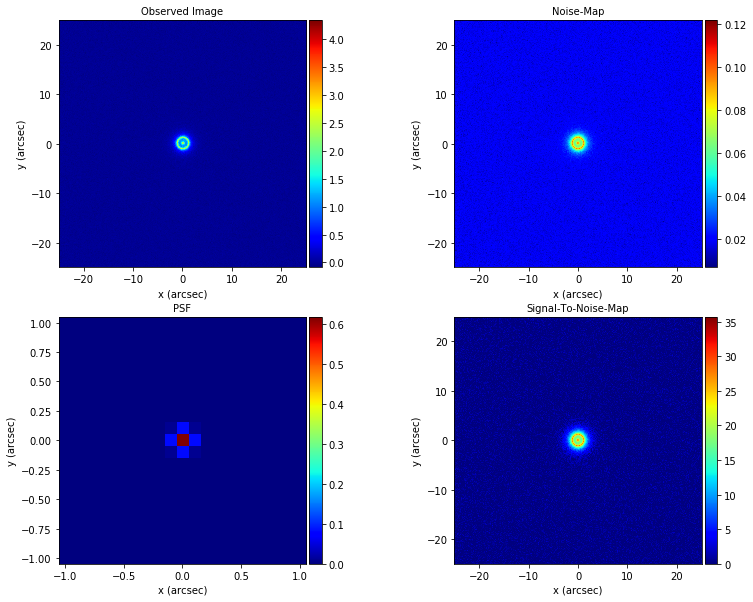

In [11]:
ccd_data_large_stamp = ccd.load_ccd_data_from_fits(image_path=path+'data/image_large_stamp/image.fits', pixel_scale=0.1,
                                                noise_map_path=path+'data/image_large_stamp/noise_map.fits',
                                                psf_path=path+'data/image_large_stamp/psf.fits')
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_large_stamp)


If you have a large postage stamp, you can trim it when you load the data by specifying a new image size in pixels. This will also trim the noise-map, exposoure time map and other arrays which are the same dimensions / scale as the image. This trimming is centred on the image.

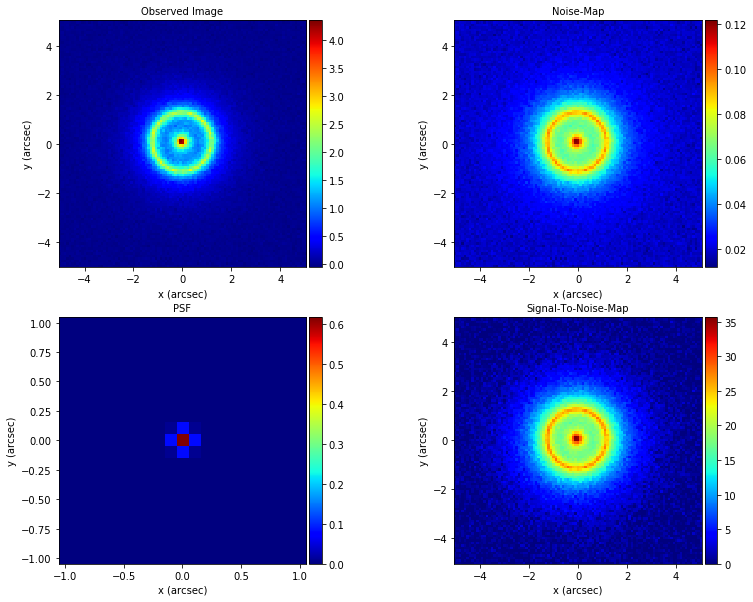

In [12]:
ccd_data_large_stamp_trimmed = ccd.load_ccd_data_from_fits(image_path=path+'data/image_large_stamp/image.fits',
                                                      pixel_scale=0.1,
                                                      noise_map_path=path+'data/image_large_stamp/noise_map.fits',
                                                      psf_path=path+'data/image_large_stamp/psf.fits',
                                                      resized_ccd_shape=(101, 101))
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_large_stamp_trimmed)

3) Postage stamp size - On the other hand, the postage stamp must have enough padding in the borders that our mask can include all pixels with signal in. In fact, it isn't just the mask that must be contained within the postage stamp, but also the mask's 'blurring region' - which corresponds to all unmasked image pixels where light will blur into the mask after PSF convolution. Thus, we may need to pad an image to include this region.

This image is an example of a stamp which is big enough to contain the lens and source galaxies, but when we apply a sensible mask we get an error, because the mask's blurring region hits the edge of the image.

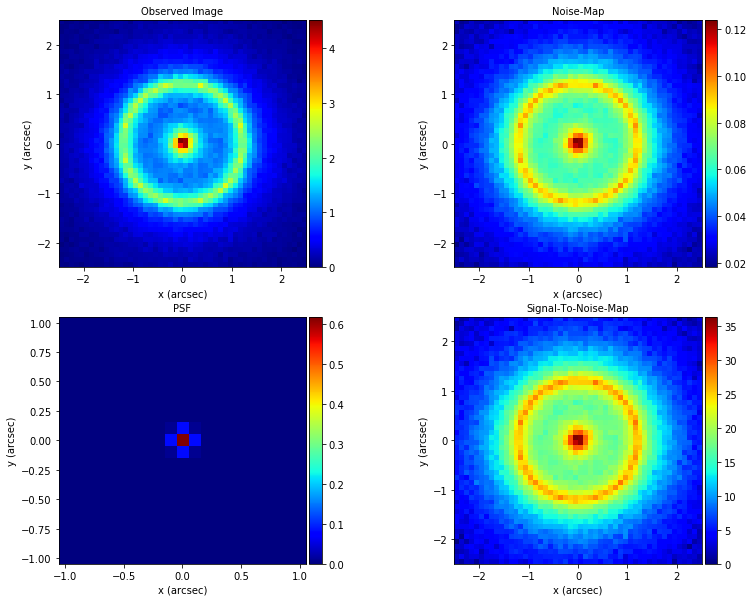

In [13]:
ccd_data_small_stamp = ccd.load_ccd_data_from_fits(image_path=path+'data/image_small_stamp/image.fits', pixel_scale=0.1,
                                              noise_map_path=path+'data/image_small_stamp/noise_map.fits',
                                              psf_path=path+'data/image_small_stamp/psf.fits')
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_small_stamp)

If we apply a mask to this image, we'll get an error when we try to use it to set up a lensing image, because its blurring region hits the image edge.

In [14]:
mask = ma.Mask.circular(shape=ccd_data_small_stamp.shape, pixel_scale=ccd_data_small_stamp.pixel_scale,
                        radius_arcsec=2.0)
lens_data = ld.LensData(ccd_data=ccd_data_small_stamp, mask=mask) # Gives an error due to the mask's blurring region hitting an edge

MaskException: setup_blurring_mask extends beyond the sub_grid_size of the masks - pad the masked_image before masking

We can overcome this using the same input as before. However, now, the resized image shape is bigger than the image, thus a padding of zeros is introduced to the edges.

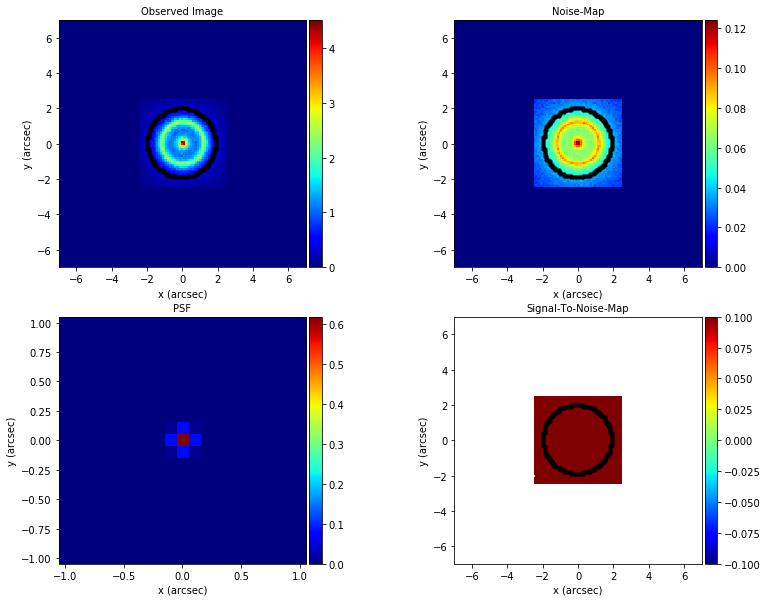

In [15]:
ccd_data_small_stamp_padded = ccd.load_ccd_data_from_fits(image_path=path+'data/image_small_stamp/image.fits',
                                                          pixel_scale=0.1,
                                                          noise_map_path=path+'data/image_small_stamp/noise_map.fits',
                                                          psf_path=path+'data/image_small_stamp/psf.fits',
                                                          resized_ccd_shape=(140, 140))
mask = ma.Mask.circular(shape=ccd_data_small_stamp_padded.shape, 
                        pixel_scale=ccd_data_small_stamp_padded.pixel_scale,
                        radius_arcsec=2.0)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_small_stamp_padded, mask=mask)
lens_data= ld.LensData(ccd_data=ccd_data_small_stamp_padded, mask=mask) # No error anymore!


IVE INCLUDED THE TEXT FOR 5 BELOW SO YOU CAN BE AWARE OF CENTERING, BUT THE BUILT IN FUNCTIONALITY FOR RECENTERING CURRENTLY DOES NOT WORK :(

5) Lens Galaxy Centering - The image should place the lens galaxy in the centre of the image, as opposed to a corner. This ensures the centre of the lens galaxy's light and mass profiles will be near the origin (0.0", 0.0"), as well as the centre of the mask, which is a more intuitive coordinate system. The priors on the light profiles and mass profile also assume a centre of (0.0", 0.0"), as well as the default mask centre.

Lets look at an off-center image - clearly both the lens galaxy and Einstein ring are offset in the positive y and x d directions.

In [16]:
# ccd_data_offset_centre = ccd.load_ccd_data_from_fits(image_path=path+'data/image_offset_centre/image.fits', pixel_scale=0.1,
#                                   noise_map_path=path+'data/image_offset_centre/noise_map.fits',
#                                   psf_path=path+'data/image_offset_centre/psf.fits')
# ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_offset_centre)

We can address this by using supplying a new centre for the image, in pixels. We also supply the resized shape, to instruct the code whether it should trim the image or pad the edges that now arise due to recentering.

In [ ]:
# ccd_data_recentred_pixels = ccd.load_ccd_data_from_fits(image_path=path+'data/image_small_stamp/image.fits', pixel_scale=0.1,
#                                             noise_map_path=path+'data/image_small_stamp/noise_map.fits',
#                                             psf_path=path+'data/image_small_stamp/psf.fits',
#                                             resized_ccd_shape=(100, 100),
#                                             resized_ccd_centre_pixels=(0, 0))
# #                                            resized_ccd_centre_arc_seconds=(1.0, 1.0))
# print(ccd_data_recentred_pixels.shape)
# ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_recentred_pixels)

6) The noise-map values are the RMS standard deviation in every pixel (and not the variances, HST WHT-map values, etc.). You MUST be 100% certain that the noise map is the RMS standard deviations, or else your analysis will be incorrect.

There are many different ways the noise-map can be reduced. We are aiming to include conversion functions for all common data-reductions. Currently, we have a function to convert an image from a HST WHT map, where RMS SD = 1.0/ sqrt(WHT). This can be called using the 'convert_noise_map_from_weight_map' flag.
    
(I don't currently have an example image in WHT for this tutorial, but the function above will work. Above, it actually converts an accurate noise-map to an inverse WHT map!

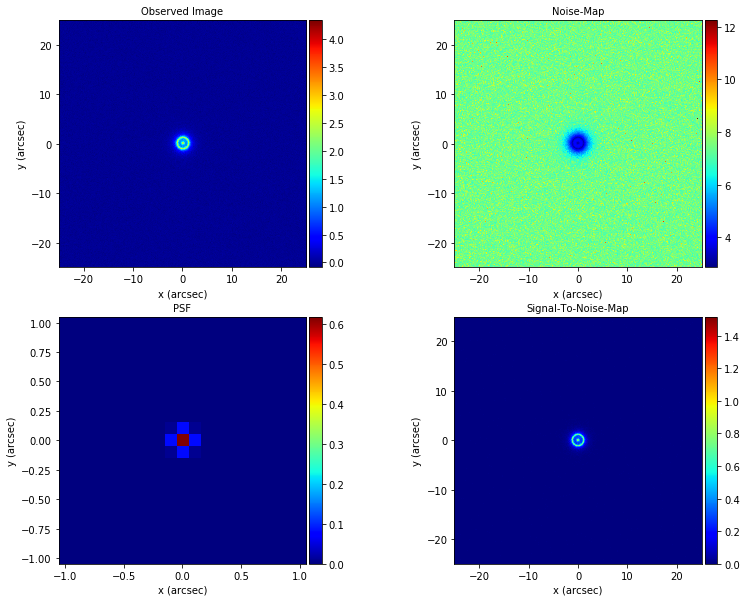

In [19]:
ccd_data_noise_from_wht = ccd.load_ccd_data_from_fits(image_path=path+'data/image_large_stamp/image.fits',
                                                      pixel_scale=0.1,
                                                      noise_map_path=path+'data/image_large_stamp/noise_map.fits',
                                                      psf_path=path+'data/image_large_stamp/psf.fits',
                                                      convert_noise_map_from_weight_map=True)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_noise_from_wht)


7) The PSF is zoomed in around its central core, which is the most important region for strong lens modeling. By default, the size of the PSF image is used to perform convolution. The larger this stamp, the longer this convolution will take to run. In geneal, we would recommend the PSF size is 21 x 21.

Lets look at an image where a large PSF kernel is loaded.

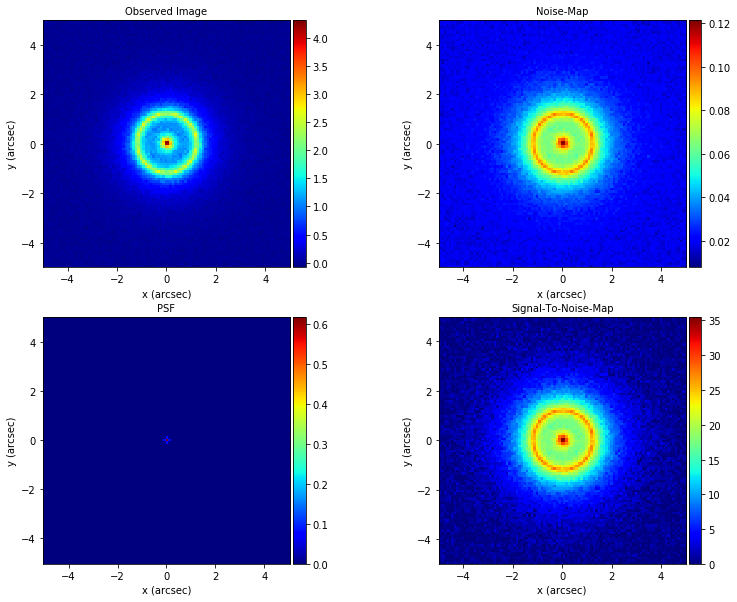

In [20]:
ccd_data_with_large_psf = ccd.load_ccd_data_from_fits(image_path=path+'data/image_with_large_psf/image.fits',
                                                      pixel_scale=0.1,
                                                      noise_map_path=path+'data/image_with_large_psf/noise_map.fits',
                                                      psf_path=path+'data/image_with_large_psf/psf.fits')
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_with_large_psf)

We can resize a psf the same way that we resize an image.

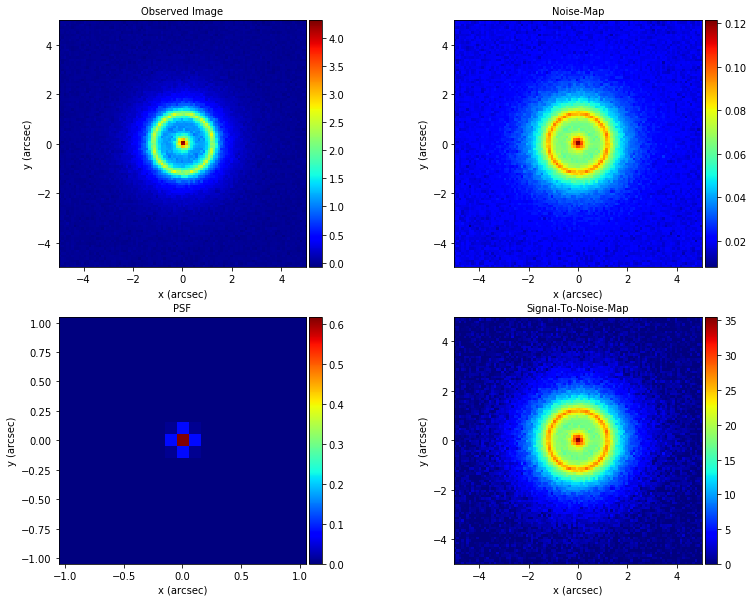

In [21]:
ccd_data_with_trimmed_psf = ccd.load_ccd_data_from_fits(image_path=path+'data/image_with_large_psf/image.fits',
                                                        pixel_scale=0.1,
                                                        noise_map_path=path+'data/image_with_large_psf/noise_map.fits',
                                                        psf_path=path+'data/image_with_large_psf/psf.fits',
                                                        resized_psf_shape=(21, 21))
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data_with_trimmed_psf)

8) The PSF dimensions are odd x odd (21 x 21). It is important that the PSF dimensions are odd, because even-sized PSF kernels introduce a half-pixel offset in the convolution routine, which can lead to systematics in the lens model analysis.

We do not currently yet have built-in functionality to address this issue. Therefore, if your PSF has an even dimension, you must manually trim and recentre it. If you need help on doing this, contact me on the PyAutoLens SLACK channel, as I'll have already written the routine to do this by the time you read this tutorial!